In [1]:
import tensorflow as tf 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2023-03-28 14:03:30.839738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 14:03:31.039688: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-28 14:03:31.039729: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-28 14:03:31.719134: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE =32
CHANNELS = 3
EPOCHS = 20

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "/home/ayush/Documents/disease_classification/dataset/potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE

)

Found 2152 files belonging to 3 classes.


2023-03-28 14:03:42.447942: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-28 14:03:42.447985: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-28 14:03:42.448009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (asip): /proc/driver/nvidia/version does not exist
2023-03-28 14:03:42.448429: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

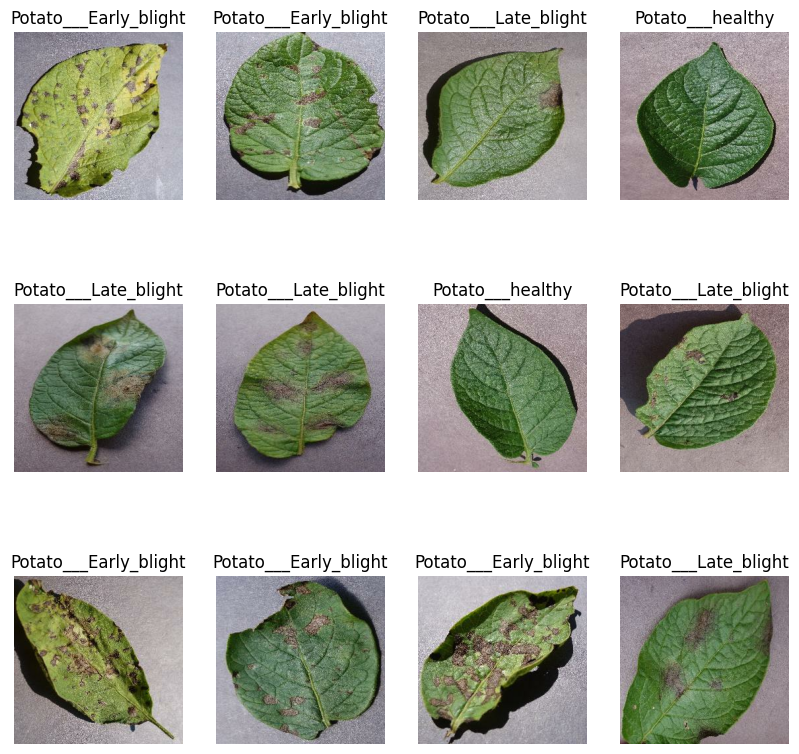

In [6]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        # print(image_batch.shape,label_batch.numpy())

In [7]:
len(dataset)

68

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)

In [10]:
val_ds = dataset.take(6)

In [11]:
test_ds = dataset.skip(6)

In [12]:
def get_dataset_partition_tf(ds,train_split = 0.8,val_split= 0.1, test_split= 0.1, shuffle = True, shuffle_size = 10000 ):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    train_ds = ds.take(int(ds_size*train_split))

    val_ds = ds.skip(int(ds_size*train_split)).take(int(val_split*ds_size))

    test_ds  = ds.skip(int(ds_size*train_split)).skip(int(val_split*ds_size))

    return train_ds,val_ds,test_ds

In [13]:
train_ds,val_ds,test_ds = get_dataset_partition_tf(dataset)

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [15]:
resize_abd_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_abd_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(64, activation = 'softmax')
])

model.build(input_shape = input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [19]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/20


2023-03-10 03:04:29.576056: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.
2023-03-10 03:04:29.589212: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.
2023-03-10 03:04:29.600387: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.
2023-03-10 03:04:29.609942: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.


54/54 [==============================] - 79s 1s/step - loss: 1.2939 - accuracy: 0.4502 - val_loss: 0.8898 - val_accuracy: 0.5573
Epoch 2/20
54/54 [==============================] - 71s 1s/step - loss: 0.8321 - accuracy: 0.6181 - val_loss: 0.7294 - val_accuracy: 0.7031
Epoch 3/20
54/54 [==============================] - 72s 1s/step - loss: 0.6495 - accuracy: 0.7286 - val_loss: 0.6912 - val_accuracy: 0.6667
Epoch 4/20
54/54 [==============================] - 73s 1s/step - loss: 0.4911 - accuracy: 0.7998 - val_loss: 0.3060 - val_accuracy: 0.8906
Epoch 5/20
54/54 [==============================] - 73s 1s/step - loss: 0.4136 - accuracy: 0.8299 - val_loss: 0.3788 - val_accuracy: 0.8490
Epoch 6/20
54/54 [==============================] - 71s 1s/step - loss: 0.3514 - accuracy: 0.8536 - val_loss: 0.3043 - val_accuracy: 0.8802
Epoch 7/20
54/54 [==============================] - 72s 1s/step - loss: 0.3186 - accuracy: 0.8791 - val_loss: 0.2450 - val_accuracy: 0.9219
Epoch 8/20
54/54 [=============

In [21]:
model.evaluate(test_ds)

8/8 [==============================] - 4s 279ms/step - loss: 0.1637 - accuracy: 0.9297


[0.16366708278656006, 0.9296875]

In [22]:
model_version = 'm2'
model.save(f'./model/{model_version}')

INFO:tensorflow:Assets written to: ./model/m2/assets


INFO:tensorflow:Assets written to: ./model/m2/assets


NameError: name 'model' is not defined